### Author: Ran Meng

This jupyter notebook contains my work for certification of "Dimensionality Reduction in Python" instructed by Jeroen Boeye, from [DataCamp](https://learn.datacamp.com/courses/dimensionality-reduction-in-python)

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import VarianceThreshold, RFE
from sklearn.linear_model import LogisticRegression, Lasso, LassoCV, LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingRegressor, RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from keras.datasets import mnist

Using TensorFlow backend.


In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
pokemon_df = pd.read_csv('pokemon.csv')

pokemon_df.shape

(800, 13)

#### Removing features without variance

To get an idea of which features have little variance you should use the IPython Shell to calculate summary statistics on this sample. Then adjust the code to create a smaller, easier to understand, dataset.

In [4]:
pokemon_df.head()

,#,Name,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
0,1,Bulbasaur,Grass,Poison,318,45,49,49,65,65,45,1,False
1,2,Ivysaur,Grass,Poison,405,60,62,63,80,80,60,1,False
2,3,Venusaur,Grass,Poison,525,80,82,83,100,100,80,1,False
3,3,VenusaurMega Venusaur,Grass,Poison,625,80,100,123,122,120,80,1,False
4,4,Charmander,Fire,NaN,309,39,52,43,60,50,65,1,False


In [5]:
# Remove the feature without variance from this list
number_cols = ['HP', 'Attack', 'Defense']

In [6]:
# Leave this list as is for now
non_number_cols = ['Name', 'Type 1', 'Legendary']

# Sub-select by combining the lists with chosen features
df_selected = pokemon_df[number_cols + non_number_cols]

# Prints the first 5 lines of the new dataframe
print(df_selected.head())

   HP  Attack  Defense                   Name Type 1  Legendary
0  45      49       49              Bulbasaur  Grass      False
1  60      62       63                Ivysaur  Grass      False
2  80      82       83               Venusaur  Grass      False
3  80     100      123  VenusaurMega Venusaur  Grass      False
4  39      52       43             Charmander   Fire      False


#### Visually detecting redundant features

Data visualization is a crucial step in any data exploration. Let's use Seaborn to explore some samples of the US Army ANSUR body measurement dataset.

In [7]:
files = ['ANSUR_II_MALE.csv', 'ANSUR_II_FEMALE.csv']

ansur_df = pd.concat((pd.read_csv(f) for f in files))

ansur_df.shape

(6068, 99)

In [8]:
ansur_df.head()

,Branch,Component,Gender,abdominalextensiondepthsitting,acromialheight,acromionradialelength,anklecircumference,axillaheight,balloffootcircumference,balloffootlength,...,waistdepth,waistfrontlengthsitting,waistheightomphalion,wristcircumference,wristheight,weight_kg,stature_m,BMI,BMI_class,Height_class
0,Combat Arms,Regular Army,Male,266,1467,337,222,1347,253,202,...,240,440,1054,175,853,81.5,1.776,25.838761,Overweight,Tall
1,Combat Support,Regular Army,Male,233,1395,326,220,1293,245,193,...,225,371,1054,167,815,72.6,1.702,25.062103,Overweight,Normal
2,Combat Support,Regular Army,Male,287,1430,341,230,1327,256,196,...,255,411,1041,180,831,92.9,1.735,30.861480,Overweight,Normal
3,Combat Service Support,Regular Army,Male,234,1347,310,230,1239,262,199,...,205,399,968,176,793,79.4,1.655,28.988417,Overweight,Normal
4,Combat Service Support,Regular Army,Male,250,1585,372,247,1478,267,224,...,214,379,1245,188,954,94.6,1.914,25.823034,Overweight,Tall


In [9]:
ansur_df_1 = ansur_df.sample(n = 200).loc[:,['Gender', 'weight_kg', 'stature_m']]
ansur_df_2 = ansur_df.sample(n = 200).loc[:,['Gender', 'footlength', 'headlength']]

ansur_df_2.shape

(200, 3)

In [10]:
ansur_df_1.head()

,Gender,weight_kg,stature_m
1430,Male,91.0,1.758
133,Female,61.4,1.633
2746,Male,70.6,1.623
738,Female,60.1,1.645
1,Male,72.6,1.702


In [11]:
ansur_df_2.head()

,Gender,footlength,headlength
3478,Male,275,204
3118,Male,271,209
2128,Male,261,193
2993,Male,254,200
1066,Female,255,187


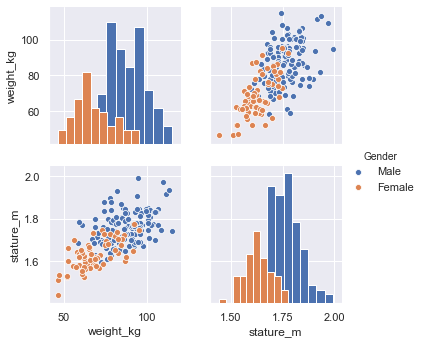

In [12]:
# Create a pairplot and color the points using the 'Gender' feature
sns.set()
sns.pairplot(ansur_df_1, hue= 'Gender', diag_kind='hist')

# Show the plot
plt.show()

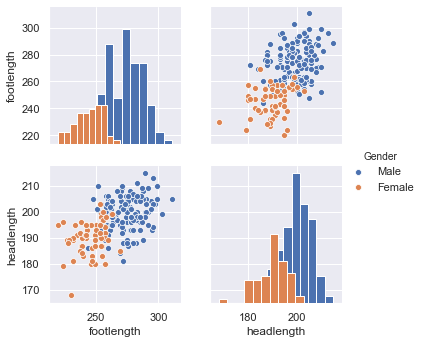

In [13]:
# Create a pairplot and color the points using the 'Gender' feature
sns.pairplot(ansur_df_2, hue='Gender', diag_kind='hist')

# Show the plot
plt.show()

#### Fitting t-SNE to the ANSUR data

t-SNE is a great technique for visual exploration of high dimensional datasets. In this exercise, you'll apply it to the ANSUR dataset. You'll remove non-numeric columns from the pre-loaded dataset *df* and fit TSNE to his numeric dataset.

In [14]:
# Non-numerical columns in the dataset
non_numeric = ['Branch', 'Gender', 'Component', 'BMI_class', 'Height_class']

# Drop the non-numerical columns from df
df_numeric = ansur_df.drop(non_numeric, axis=1)
print(df_numeric.shape)

# Create a t-SNE model with learning rate 50
m = TSNE(learning_rate=50)

# Fit and transform the t-SNE model on the numeric dataset
tsne_features = m.fit_transform(df_numeric)
print(tsne_features.shape)

(6068, 94)
(6068, 2)


In [15]:
tsne_features[:,0]

array([ 16.945635,   8.085948,  17.131863, ..., -31.091421, -50.088825,
       -38.10138 ], dtype=float32)

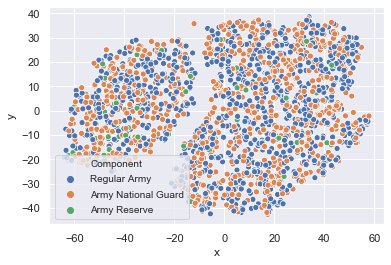

In [16]:
ansur_df['x'] = tsne_features[:,0]
ansur_df['y'] = tsne_features[:,1]

df = ansur_df.sample(n = 2000)

# Color the points according to Army Component
ax = sns.scatterplot(x="x", y="y", hue='Component', data=df)
plt.setp(ax.get_legend().get_texts(), fontsize='10')

# Show the plot
plt.show()

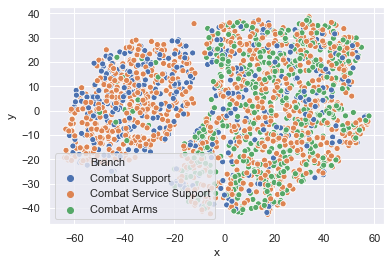

In [17]:
# Color the points by Army Branch
sns.scatterplot(x="x", y="y", hue='Branch', data=df)

# Show the plot
plt.show()

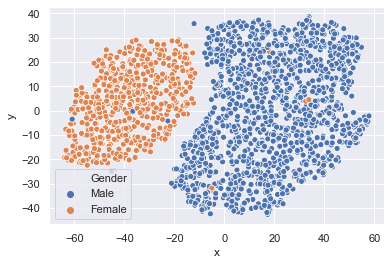

In [18]:
# Color the points by Gender
sns.scatterplot(x="x", y="y", hue='Gender', data=df)

# Show the plot
plt.show()

#There is a Male and a Female cluster. t-SNE found these gender differences in body shape 
#without being told about them explicitly! From the second plot you learned there are more males 
#in the Combat Arms Branch.

#### Train - test split

In this chapter, you will keep working with the ANSUR dataset. Before you can build a model on your dataset, you should first decide on which feature you want to predict. In this case, you're trying to predict gender.

You need to extract the column holding this feature from the dataset and then split the data into a training and test set. The training set will be used to train the model and the test set will be used to check its performance on unseen data.

In [19]:
non_numeric = ['Branch', 'Component', 'BMI_class', 'Height_class']

df_numeric = ansur_df.drop(non_numeric, axis = 1)
print(df_numeric.shape)

(6068, 97)


In [20]:
# Select the Gender column as the feature to be predicted (y)
y = df_numeric['Gender']

# Remove the Gender column to create the training data
X = df_numeric.drop('Gender', axis = 1)

# Perform a 70% train and 30% test data split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

print("{} rows in test set vs. {} in training set. {} Features.".format(X_test.shape[0], X_train.shape[0], X_test.shape[1]))


1821 rows in test set vs. 4247 in training set. 96 Features.


#### Fitting and testing the model

In the previous exercise, you split the dataset into X_train, X_test, y_train, and y_test. These datasets have been pre-loaded for you. You'll now create a support vector machine classifier model (SVC()) and fit that to the training data. You'll then calculate the accuracy on both the test and training set to detect overfitting.

In [21]:
# Create an instance of the Support Vector Classification class
svc = SVC()

# Fit the model to the training data
svc.fit(X_train, y_train)

# Calculate accuracy scores on both train and test data
accuracy_train = accuracy_score(y_train, svc.predict(X_train))
accuracy_test = accuracy_score(y_test, svc.predict(X_test))


# The model is severely overfitting!
print("{0:.1%} accuracy on test set vs. {1:.1%} on training set".format(accuracy_test, accuracy_train))

67.0% accuracy on test set vs. 100.0% on training set


#### Accuracy after dimensionality reduction

You'll reduce the overfit with the help of dimensionality reduction. In this case, you'll apply a rather drastic form of dimensionality reduction by only selecting a single column that has some good information to distinguish between genders. You'll repeat the train-test split, model fit and prediction steps to compare the accuracy on test vs. training data.

In [22]:
# Assign just the 'neckcircumferencebase' column from ansur_df to X
X = df_numeric[['neckcircumferencebase']]

# Split the data, instantiate a classifier and fit the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
svc = SVC()
svc.fit(X_train, y_train)

# Calculate accuracy scores on both train and test data
accuracy_train = accuracy_score(y_train, svc.predict(X_train))
accuracy_test = accuracy_score(y_test, svc.predict(X_test))

print("{0:.1%} accuracy on test set vs. {1:.1%} on training set".format(accuracy_test, accuracy_train))

93.7% accuracy on test set vs. 93.2% on training set


#### Finding a good variance threshold
You'll be working on a slightly modified subsample of the ANSUR dataset with just head measurements 

In [23]:
head_df = ansur_df.loc[:, ['headbreadth','headcircumference','headlength','tragiontopofhead']]

head_df['n_hairs'] = np.random.normal(loc = 100000, scale = 20, size = len(head_df))
head_df['measurement_error'] = 0.1

In [24]:
print(head_df.shape)
head_df.head()

(6068, 6)


,headbreadth,headcircumference,headlength,tragiontopofhead,n_hairs,measurement_error
0,150,583,206,140,99999.589401,0.1
1,146,568,201,120,100004.579413,0.1
2,148,573,202,125,99994.146761,0.1
3,158,576,199,127,100037.678714,0.1
4,153,566,197,122,99991.505585,0.1


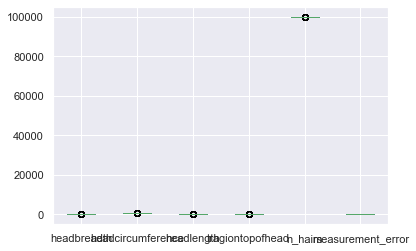

In [25]:
# Create the boxplot
head_df.boxplot()
plt.show()

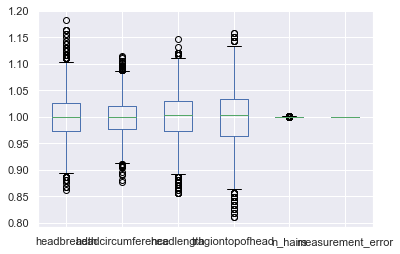

In [26]:
# Normalize the data
normalized_df = head_df / head_df.mean()

normalized_df.boxplot()
plt.show()

In [27]:
# Print the variances of the normalized data
print(normalized_df.var())

headbreadth          1.678952e-03
headcircumference    1.029623e-03
headlength           1.867872e-03
tragiontopofhead     2.639840e-03
n_hairs              3.986818e-08
measurement_error    3.231707e-27
dtype: float64


#### Features with low variance

In the previous exercise you established that 0.001 is a good threshold to filter out low variance features in head_df after normalization. Now use the VarianceThreshold feature selector to remove these features.

In [28]:
# Create a VarianceThreshold feature selector
sel = VarianceThreshold(threshold=0.001)

# Fit the selector to normalized head_df
sel.fit(head_df / head_df.mean())

# Create a boolean mask
mask = sel.get_support()

# Apply the mask to create a reduced dataframe
reduced_df = head_df.loc[:, mask]

print("Dimensionality reduced from {} to {}.".format(head_df.shape[1], reduced_df.shape[1]))

Dimensionality reduced from 6 to 4.


#### Removing features with many missing values

You'll apply feature selection on the Boston Public Schools dataset *school_df*. Calculate the missing value ratio per feature and then create a mask to remove features with many missing values.

In [29]:
school_df = pd.read_csv('Public_Schools.csv')

In [30]:
print(school_df.shape)
school_df.head()

(131, 21)


,x,y,objectid_1,objectid,bldg_id,bldg_name,address,city,zipcode,csp_sch_id,...,sch_name,sch_label,sch_type,shared,complex,label,tlt,pl,point_x,point_y
0,-71.004121,42.388799,1,1,1,Guild Bldg,195 Leyden Street,East Boston,2128,4061,...,Guild Elementary,Guild,ES,NaN,NaN,52,3,Grace,790128.152748,2.967094e+06
1,-71.030480,42.378545,2,2,3,"Kennedy, P Bldg",343 Saratoga Street,East Boston,2128,4541,...,Kennedy Patrick Elem,PJ Kennedy,ES,NaN,NaN,72,3,Grace,783027.745829,2.963318e+06
2,-71.033891,42.375279,3,3,4,Otis Bldg,218 Marion Street,East Boston,2128,4322,...,Otis Elementary,Otis,ES,NaN,NaN,106,3,Grace,782112.823908,2.962122e+06
3,-71.038011,42.378089,4,4,6,Odonnell Bldg,33 Trenton Street,East Boston,2128,4543,...,O'Donnell Elementary,O'Donnell,ES,NaN,NaN,103,3,Grace,780994.000003,2.963140e+06
4,-71.034921,42.380957,5,5,7,East Boston High Bldg,86 White Street,East Boston,2128,1070,...,East Boston High,East Boston HS,HS,NaN,NaN,36,2,Joel,781823.000004,2.964190e+06


In [31]:
school_df.isna().sum()/len(school_df)

x             0.000000
y             0.000000
objectid_1    0.000000
objectid      0.000000
bldg_id       0.000000
bldg_name     0.000000
address       0.000000
city          0.000000
zipcode       0.000000
csp_sch_id    0.000000
sch_id        0.000000
sch_name      0.000000
sch_label     0.000000
sch_type      0.000000
shared        0.877863
complex       0.984733
label         0.000000
tlt           0.000000
pl            0.000000
point_x       0.000000
point_y       0.000000
dtype: float64

In [32]:
# Create a boolean mask on whether each feature less than 50% missing values.
mask = school_df.isna().sum() / len(school_df) < 0.5

# Create a reduced dataset by applying the mask
reduced_df = school_df.loc[:, mask]

print(school_df.shape)
print(reduced_df.shape)

(131, 21)
(131, 19)


#### Inspecting the correlation matrix

A sample of the ANSUR body measurements dataset has been pre-loaded as *df*. Use the terminal to create a correlation matrix for this dataset.

In [33]:
df = ansur_df.loc[:, ['elbowrestheight', 'wristcircumference',  'anklecircumference', 'buttockheight', 'crotchheight']]

In [34]:
print(df.shape)

df.head()

(6068, 5)


,elbowrestheight,wristcircumference,anklecircumference,buttockheight,crotchheight
0,247,175,222,882,877
1,232,167,220,870,851
2,237,180,230,901,854
3,272,176,230,821,769
4,188,188,247,1080,1014


#### Visualizing the correlation matrix

Reading the correlation matrix of ansur_df in its raw, numeric format doesn't allow us to get a quick overview. Let's improve this by removing redundant values and visualizing the matrix using seaborn.

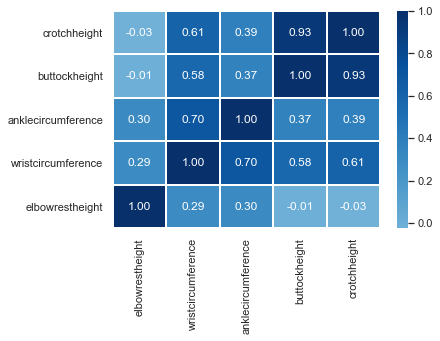

In [35]:
corr = df.corr()

# Draw the heatmap
ax = sns.heatmap(corr, center = 0, linewidth = 1, cmap = 'Blues', annot=True, fmt=".2f")
ax.set_ylim(0, 5) 
plt.show()

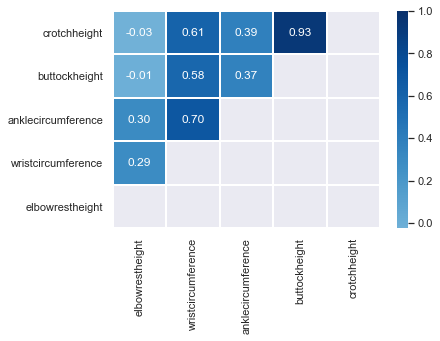

In [36]:
# Generate a mask for the upper triangle 
mask = np.triu(np.ones_like(corr, dtype=bool))

# Add the mask to the heatmap
ax = sns.heatmap(corr, mask=mask, cmap = 'Blues', center=0, linewidths=1, annot=True, fmt=".2f")
ax.set_ylim(0, 5)
plt.show()

#### Filtering out highly correlated features

You're going to automate the removal of highly correlated features in the numeric ANSUR dataset. You'll calculate the correlation matrix and filter out columns that have a correlation coefficient of more than 0.95 or less than -0.95.

Since each correlation coefficient occurs twice in the matrix (correlation of A to B equals correlation of B to A) you'll want to ignore half of the correlation matrix so that only one of the two correlated features is removed. Use a mask trick for this purpose.

In [37]:
# Calculate the correlation matrix and take the absolute value
corr_matrix = ansur_df.corr().abs()

# Create a True/False mask and apply it
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
tri_df = corr_matrix.mask(mask)

# List column names of highly correlated features (r > 0.95)
to_drop = [c for c in tri_df.columns if any(tri_df[c] >  0.95)]

# Drop the features in the to_drop list
reduced_df = ansur_df.drop(to_drop, axis=1)

print("The reduced dataframe has {} columns.".format(reduced_df.shape[1]))

The reduced dataframe has 82 columns.


#### Building a diabetes classifier

You'll be using the Pima Indians diabetes dataset to predict whether a person has diabetes using logistic regression.

In [38]:
diabetes_df = pd.read_csv('PimaIndians.csv')

diabetes_df.shape

(392, 9)

In [39]:
diabetes_df.head()

,pregnant,glucose,diastolic,triceps,insulin,bmi,family,age,test
0,1,89,66,23,94,28.1,0.167,21,negative
1,0,137,40,35,168,43.1,2.288,33,positive
2,3,78,50,32,88,31.0,0.248,26,positive
3,2,197,70,45,543,30.5,0.158,53,positive
4,1,189,60,23,846,30.1,0.398,59,positive


In [40]:
y = diabetes_df['test']

# Remove the Test column to create the training data
X = diabetes_df.drop('test', axis = 1)

print(X.shape)
print(y.shape)

(392, 8)
(392,)


In [41]:
# Split the data, instantiate a classifier and fit the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

print(len(X_train))
print(len(X_test))

274
118


In [42]:
lr = LogisticRegression()
scaler = StandardScaler()

# Fit the scaler on the training features and transform these in one go
X_train_std = scaler.fit_transform(X_train)

# Fit the logistic regression model on the scaled training data
lr.fit(X_train_std, y_train)

# Scale the test features
X_test_std = scaler.transform(X_test)

# Predict diabetes presence on the scaled test set
y_pred = lr.predict(X_test_std)

# Prints accuracy metrics and feature coefficients
print("{0:.1%} accuracy on test set.".format(accuracy_score(y_test, y_pred))) 
print(dict(zip(X.columns, abs(lr.coef_[0]).round(2))))

80.5% accuracy on test set.
{'pregnant': 0.44, 'glucose': 1.13, 'diastolic': 0.07, 'triceps': 0.15, 'insulin': 0.06, 'bmi': 0.21, 'family': 0.56, 'age': 0.14}


#### Manual Recursive Feature Elimination

Now that we've created a diabetes classifier, let's see if we can reduce the number of features without hurting the model accuracy too much.

On the second line of code the features are selected from the original dataframe. Adjust this selection.

In [43]:
# First, run the given code, then remove the feature with the lowest model coefficient from X.

# Remove the feature with the lowest model coefficient
X = diabetes_df[['pregnant', 'glucose', 'triceps', 'insulin', 'bmi', 'family', 'age']]

# Performs a 25-75% train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

# Scales features and fits the logistic regression model
lr.fit(scaler.fit_transform(X_train), y_train)

# Calculates the accuracy on the test set and prints coefficients
acc = accuracy_score(y_test, lr.predict(scaler.transform(X_test)))
print("{0:.1%} accuracy on test set.".format(acc)) 
print(dict(zip(X.columns, abs(lr.coef_[0]).round(2))))

80.6% accuracy on test set.
{'pregnant': 0.05, 'glucose': 1.23, 'triceps': 0.24, 'insulin': 0.2, 'bmi': 0.39, 'family': 0.34, 'age': 0.35}


In [44]:
# Run the code and remove 2 more features with the lowest model coefficients.

# Remove the 2 features with the lowest model coefficients
X = diabetes_df[[ 'glucose', 'triceps', 'bmi', 'family', 'age']]

# Performs a 25-75% train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

# Scales features and fits the logistic regression model
lr.fit(scaler.fit_transform(X_train), y_train)

# Calculates the accuracy on the test set and prints coefficients
acc = accuracy_score(y_test, lr.predict(scaler.transform(X_test)))
print("{0:.1%} accuracy on test set.".format(acc)) 
print(dict(zip(X.columns, abs(lr.coef_[0]).round(2))))

79.6% accuracy on test set.
{'glucose': 1.13, 'triceps': 0.25, 'bmi': 0.34, 'family': 0.34, 'age': 0.37}


In [45]:
# Run the code and only keep the feature with the highest coefficient
# Only keep the feature with the highest coefficient
X = diabetes_df[['glucose']]

# Performs a 25-75% train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

# Scales features and fits the logistic regression model to the data
lr.fit(scaler.fit_transform(X_train), y_train)

# Calculates the accuracy on the test set and prints coefficients
acc = accuracy_score(y_test, lr.predict(scaler.transform(X_test)))
print("{0:.1%} accuracy on test set.".format(acc)) 
print(dict(zip(X.columns, abs(lr.coef_[0]).round(2))))

76.5% accuracy on test set.
{'glucose': 1.27}


#### Automatic Recursive Feature Elimination

Now let's automate this recursive process. Wrap a Recursive Feature Eliminator (RFE) around our logistic regression estimator and pass it the desired number of features.

In [46]:
y = diabetes_df['test']

# Remove the Test column to create the training data
X = diabetes_df.drop('test', axis = 1)

# Performs a 25-75% train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

In [47]:
# Create the RFE with a LogisticRegression estimator and 3 features to select
rfe = RFE(estimator=LogisticRegression(), n_features_to_select=3, verbose=1)

# Fits the eliminator to the data
rfe.fit(X_train, y_train)

# Print the features and their ranking (high = dropped early on)
print(dict(zip(X.columns, rfe.ranking_)))

# Print the features that are not eliminated
print(X.columns[rfe.support_])

# Calculates the test set accuracy
acc = accuracy_score(y_test, rfe.predict(X_test))
print("{0:.1%} accuracy on test set.".format(acc)) 

Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
{'pregnant': 1, 'glucose': 1, 'diastolic': 3, 'triceps': 2, 'insulin': 6, 'bmi': 5, 'family': 1, 'age': 4}
Index(['pregnant', 'glucose', 'family'], dtype='object')
80.6% accuracy on test set.


#### Building a random forest model

You'll again work on the Pima Indians dataset to predict whether an individual has diabetes. This time using a random forest classifier. You'll fit the model on the training data after performing the train-test split and consult the feature importance values.

In [48]:
# Perform a 75% training and 25% test data split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

# Fit the random forest model to the training data
rf = RandomForestClassifier(random_state=0)
rf.fit(X_train, y_train)

# Calculate the accuracy
acc = accuracy_score(rf.predict(X_test), y_test)

# Print the importances per feature
print(dict(zip(X.columns, rf.feature_importances_.round(2))))

# Print accuracy
print("{0:.1%} accuracy on test set.".format(acc))

{'pregnant': 0.09, 'glucose': 0.21, 'diastolic': 0.08, 'triceps': 0.11, 'insulin': 0.13, 'bmi': 0.09, 'family': 0.12, 'age': 0.16}
77.6% accuracy on test set.


#### Random forest for feature selection

Now lets use the fitted random model to select the most important features from our input dataset X.

In [49]:
# Create a mask for features importances above the threshold
mask = rf.feature_importances_ > 0.15

# Prints out the mask
print(mask)

[False  True False False False False False  True]


In [50]:
# Apply the mask to the feature dataset X
reduced_X = X.loc[:,mask]

# prints out the selected column names
print(reduced_X.columns)

Index(['glucose', 'age'], dtype='object')


#### Recursive Feature Elimination with random forests

You'll wrap a Recursive Feature Eliminator around a random forest model to remove features step by step. This method is more conservative compared to selecting features after applying a single importance threshold. Since dropping one feature can influence the relative importances of the others.

In [51]:
# Perform a 75% training and 25% test data split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)


# Wrap the feature eliminator around the random forest model
rfe = RFE(estimator=RandomForestClassifier(), n_features_to_select=2, verbose=1)

# Fit the model to the training data
rfe.fit(X_train, y_train)

# Create a mask using an attribute of rfe
mask = rfe.support_

# Apply the mask to the feature dataset X and print the result
reduced_X = X.loc[:, mask]
print(reduced_X.columns)

Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Index(['glucose', 'insulin'], dtype='object')


In [52]:
# Change the settings to remove 2 features at a time
# Set the feature eliminator to remove 2 features on each step
rfe = RFE(estimator=RandomForestClassifier(), n_features_to_select=2, step = 2, verbose=1)

# Fit the model to the training data
rfe.fit(X_train, y_train)

# Create a mask
mask = rfe.support_

# Apply the mask to the feature dataset X and print the result
reduced_X = X.loc[:, mask]
print(reduced_X.columns)

Fitting estimator with 8 features.
Fitting estimator with 6 features.
Fitting estimator with 4 features.
Index(['glucose', 'bmi'], dtype='object')


#### Creating a LASSO regressor

You'll be working on the numeric ANSUR body measurements dataset to predict a persons Body Mass Index (BMI) using the pre-imported Lasso() regressor. BMI is a metric derived from body height and weight but those two features have been removed from the dataset to give the model a challenge.

You'll standardize the data first using the StandardScaler() that has been instantiated for you as scaler to make sure all coefficients face a comparable regularizing force trying to bring them down.

In [53]:
non_numeric = ['Gender', 'Branch', 'Component', 'BMI_class', 'Height_class']

df_numeric = ansur_df.drop(non_numeric, axis = 1)
df_numeric.shape

(6068, 96)

In [54]:
y = df_numeric['BMI']

X = df_numeric.drop('BMI', axis = 1)

print(X.shape)
print(y.shape)

(6068, 95)
(6068,)


In [55]:
# Set the test size to 30% to get a 70-30% train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

# Fit the scaler on the training features and transform these in one go
X_train_std = scaler.fit_transform(X_train)

# Create the Lasso model
la = Lasso()

# Fit it to the standardized training data
la.fit(X_train_std, y_train)

Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [56]:
# Transform the test set with the pre-fitted scaler
X_test_std = scaler.transform(X_test)

# Calculate the coefficient of determination (R squared) on X_test_std
r_squared = la.score(X_test_std, y_test)
print("The model can predict {0:.1%} of the variance in the test set.".format(r_squared))

# Create a list that has True values when coefficients equal 0
zero_coef = la.coef_ == 0

# Calculate how many features have a zero coefficient
n_ignored = sum(zero_coef)
print("The model has ignored {} out of {} features.".format(n_ignored, len(la.coef_)))

The model can predict 83.0% of the variance in the test set.
The model has ignored 84 out of 95 features.


#### Adjusting the regularization strength

Your current Lasso model has an $R^2$ score of 82.9%. When a model applies overly powerful regularization it can suffer from high bias, hurting its predictive power.

Let's improve the balance between predictive power and model simplicity by tweaking the alpha parameter.

In [57]:
# Find the highest alpha value with R-squared above 98%
la = Lasso(alpha = 0.1, random_state=0)

# Fits the model and calculates performance stats
la.fit(X_train_std, y_train)
r_squared = la.score(X_test_std, y_test)
n_ignored_features = sum(la.coef_ == 0)

# Print peformance stats 
print("The model can predict {0:.1%} of the variance in the test set.".format(r_squared))
print("{} out of {} features were ignored.".format(n_ignored_features, len(la.coef_)))

The model can predict 98.5% of the variance in the test set.
71 out of 95 features were ignored.


#### Creating a LassoCV regressor

You'll be predicting biceps circumference on a subsample of the male ANSUR dataset using the LassoCV() regressor that automatically tunes the regularization strength (alpha value) using Cross-Validation.

In [58]:
# Create and fit the LassoCV model on the training set
lcv = LassoCV(max_iter=3000)
lcv.fit(X_train, y_train)
print('Optimal alpha = {0:.3f}'.format(lcv.alpha_))

# Calculate R squared on the test set
r_squared = lcv.score(X_test, y_test)
print('The model explains {0:.1%} of the test set variance'.format(r_squared))

# Create a mask for coefficients not equal to zero
lcv_mask = lcv.coef_ != 0
print('{} features out of {} selected'.format(sum(lcv_mask), len(lcv_mask)))

Optimal alpha = 0.406
The model explains 98.9% of the test set variance
38 features out of 95 selected


#### Ensemble models for extra votes

The LassoCV() model selected 38 out of 95 features. Not bad, but not a spectacular dimensionality reduction either. Let's use two more models to select the 30 features they consider most important using the Recursive Feature Eliminator (RFE).

In [59]:
# Select 20 features with RFE on a GradientBoostingRegressor, drop 3 features on each step
rfe_gb = RFE(estimator=GradientBoostingRegressor(), 
             n_features_to_select=30, step=3, verbose=1)
rfe_gb.fit(X_train, y_train)

Fitting estimator with 95 features.
Fitting estimator with 92 features.
Fitting estimator with 89 features.
Fitting estimator with 86 features.
Fitting estimator with 83 features.
Fitting estimator with 80 features.
Fitting estimator with 77 features.
Fitting estimator with 74 features.
Fitting estimator with 71 features.
Fitting estimator with 68 features.
Fitting estimator with 65 features.
Fitting estimator with 62 features.
Fitting estimator with 59 features.
Fitting estimator with 56 features.
Fitting estimator with 53 features.
Fitting estimator with 50 features.
Fitting estimator with 47 features.
Fitting estimator with 44 features.
Fitting estimator with 41 features.
Fitting estimator with 38 features.
Fitting estimator with 35 features.
Fitting estimator with 32 features.


RFE(estimator=GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_sampl...=None, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False),
  n_features_to_select=30, step=3, verbose=1)

In [60]:
# Calculate the R squared on the test set
r_squared = rfe_gb.score(X_test, y_test)
print('The model can explain {0:.1%} of the variance in the test set'.format(r_squared))

# Assign the support array to gb_mask
gb_mask = rfe_gb.support_

The model can explain 97.6% of the variance in the test set


In [61]:
# Select 30 features with RFE on a RandomForestRegressor, drop 3 features on each step
rfe_rf = RFE(estimator=RandomForestRegressor(), 
             n_features_to_select=30, step=3, verbose=1)
rfe_rf.fit(X_train, y_train)

# Calculate the R squared on the test set
r_squared = rfe_rf.score(X_test, y_test)
print('The model can explain {0:.1%} of the variance in the test set'.format(r_squared))

# Assign the support array to rf_mask
rf_mask = rfe_rf.support_

Fitting estimator with 95 features.
Fitting estimator with 92 features.
Fitting estimator with 89 features.
Fitting estimator with 86 features.
Fitting estimator with 83 features.
Fitting estimator with 80 features.
Fitting estimator with 77 features.
Fitting estimator with 74 features.
Fitting estimator with 71 features.
Fitting estimator with 68 features.
Fitting estimator with 65 features.
Fitting estimator with 62 features.
Fitting estimator with 59 features.
Fitting estimator with 56 features.
Fitting estimator with 53 features.
Fitting estimator with 50 features.
Fitting estimator with 47 features.
Fitting estimator with 44 features.
Fitting estimator with 41 features.
Fitting estimator with 38 features.
Fitting estimator with 35 features.
Fitting estimator with 32 features.
The model can explain 96.7% of the variance in the test set


#### Combining 3 feature selectors

We'll combine the votes of the 3 models you built in the previous exercises, to decide which features are important into a meta mask. We'll then use this mask to reduce dimensionality and see how a simple linear regressor performs on the reduced dataset.

In [62]:
# Sum the votes of the three models
votes = np.sum([lcv_mask, rf_mask, gb_mask], axis = 0)
print(votes)

[3 0 0 0 3 0 0 0 3 0 2 0 1 0 1 2 3 0 0 0 3 2 0 3 3 1 0 1 1 0 0 0 1 2 0 0 0
 3 2 0 1 0 0 0 0 0 0 1 1 0 0 3 1 1 0 0 0 0 0 3 0 3 0 0 0 2 0 2 0 0 3 1 0 1
 2 2 3 3 1 3 0 2 1 1 0 3 3 0 3 0 1 3 2 0 2]


In [63]:
# Create a mask for features selected by all 3 models
meta_mask = votes >=3
print(meta_mask)

# Apply the dimensionality reduction on X
X_reduced = X.loc[:, meta_mask]
print('\n', X_reduced.columns)


[ True False False False  True False False False  True False False False
 False False False False  True False False False  True False False  True
  True False False False False False False False False False False False
 False  True False False False False False False False False False False
 False False False  True False False False False False False False  True
 False  True False False False False False False False False  True False
 False False False False  True  True False  True False False False False
 False  True  True False  True False False  True False False False]

 Index(['abdominalextensiondepthsitting', 'axillaheight',
       'bicepscircumferenceflexed', 'buttockdepth', 'calfcircumference',
       'chestcircumference', 'chestdepth', 'forearmcircumferenceflexed',
       'iliocristaleheight', 'lowerthighcircumference', 'neckcircumference',
       'sittingheight', 'thighcircumference', 'thighclearance', 'tibialheight',
       'waistcircumference', 'waistdepth', 'waistheightomph

In [64]:
# Plug the reduced dataset into a linear regression pipeline
X_train, X_test, y_train, y_test = train_test_split(X_reduced, y, test_size=0.3, random_state=0)

lm = LinearRegression()

lm.fit(scaler.fit_transform(X_train), y_train)
r_squared = lm.score(scaler.transform(X_test), y_test)
print('The model can explain {0:.1%} of the variance in the test set using {1:} features.'.format(r_squared, len(lm.coef_)))

# With all 3 models ensembled we are able to reach a high accuracy with just 20 features

The model can explain 98.9% of the variance in the test set using 19 features.


#### Manual feature extraction I

You want to compare prices for specific products between stores. The features in the pre-loaded dataset sales_df are: storeID, product, quantity and revenue. The quantity and revenue features tell you how many items of a particular product were sold in a store and what the total revenue was. For the purpose of your analysis it's more interesting to know the average price per product.

In [65]:
sales_df = pd.read_csv('grocery_sales.csv')

sales_df.shape

(78, 4)

In [66]:
print(sales_df.head())

  storeID  product  quantity  revenue
0       A   Apples      1811   9300.6
1       A  Bananas      1003   3375.2
2       A  Oranges      1604   8528.5
3       B   Apples      1785   9181.0
4       B  Bananas       944   3680.2


In [67]:
# Calculate the price from the quantity sold and revenue
sales_df['price'] = sales_df['revenue']/sales_df['quantity']

# Drop the quantity and revenue features
reduced_df = sales_df.drop(['revenue', 'quantity'], axis=1)

print(reduced_df.head())

  storeID  product     price
0       A   Apples  5.135616
1       A  Bananas  3.365105
2       A  Oranges  5.317020
3       B   Apples  5.143417
4       B  Bananas  3.898517


#### Calculating Principal Components

You'll visually inspect a 4 feature sample of the ANSUR dataset before and after PCA using Seaborn's pairplot(). This will allow you to inspect the pairwise correlations between the features.

In [68]:
df = ansur_df.loc[:, ['stature_m', 'buttockheight', 'waistdepth', 'span', 'waistcircumference', 'shouldercircumference', 'footlength',\
                      'handlength', 'functionalleglength', 'chestheight', 'chestcircumference', 'cervicaleheight', 'sittingheight']]

In [69]:
df.shape

(6068, 13)

In [70]:
# Scale the data
scaler = StandardScaler()
ansur_std = scaler.fit_transform(df)

# Apply PCA
pca = PCA()
pca.fit(ansur_std) # No need to transform because we are not using the principle components themselves

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [71]:
# Inspect the explained variance ratio per component
print(pca.explained_variance_ratio_)

[6.96695776e-01 1.65318195e-01 4.41759304e-02 3.10140882e-02
 1.96244729e-02 1.05810800e-02 1.00183486e-02 7.58854596e-03
 5.29894105e-03 4.64328943e-03 2.69987761e-03 1.87568473e-03
 4.65770148e-04]


In [72]:
# Print the cumulative sum of the explained variance ratio
print(pca.explained_variance_ratio_.cumsum())

# Using only 3 components we can explain more than 90% of the variance

[0.69669578 0.86201397 0.9061899  0.93720399 0.95682846 0.96740954
 0.97742789 0.98501644 0.99031538 0.99495867 0.99765855 0.99953423
 1.        ]


#### Understanding the components

You'll apply PCA to the numeric features of the Pokemon dataset, *poke_df*, using a pipeline to combine the feature scaling and PCA in one go. You'll then interpret the meanings of the first two components.

In [73]:
poke_df = pd.read_csv('pokemon.csv')

poke_df.shape

(800, 13)

In [74]:
poke_df.head()

,#,Name,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
0,1,Bulbasaur,Grass,Poison,318,45,49,49,65,65,45,1,False
1,2,Ivysaur,Grass,Poison,405,60,62,63,80,80,60,1,False
2,3,Venusaur,Grass,Poison,525,80,82,83,100,100,80,1,False
3,3,VenusaurMega Venusaur,Grass,Poison,625,80,100,123,122,120,80,1,False
4,4,Charmander,Fire,NaN,309,39,52,43,60,50,65,1,False


In [75]:
df = poke_df.loc[:, ['HP', 'Attack', 'Defense', 'Sp. Atk', 'Sp. Def', 'Speed']]

# Build the pipeline
pipe = Pipeline([('scaler', StandardScaler()),
        		 ('reducer', PCA(n_components=2))])

# Fit it to the dataset and extract the component vectors
pipe.fit(df)
vectors = pipe.steps[1][1].components_.round(2)

# Print feature effects
print('PC 1 effects = ' + str(dict(zip(df.columns, vectors[0]))))
print('PC 2 effects = ' + str(dict(zip(df.columns, vectors[1]))))

PC 1 effects = {'HP': 0.39, 'Attack': 0.44, 'Defense': 0.36, 'Sp. Atk': 0.46, 'Sp. Def': 0.45, 'Speed': 0.34}
PC 2 effects = {'HP': 0.08, 'Attack': -0.01, 'Defense': 0.63, 'Sp. Atk': -0.31, 'Sp. Def': 0.24, 'Speed': -0.67}


All features have a similar positive effect. PC 1 can be interpreted as a measure of overall quality (high stats).

Defense has a strong positive effect on the second component and speed a strong negative one. This component quantifies an agility vs. armor & protection trade-off.

#### PCA for feature exploration

You'll use the PCA pipeline you've built in the previous exercise to visually explore how some categorical features relate to the variance in poke_df. These categorical features (Type & Legendary) can be found in a separate dataframe poke_cat_df.

In [76]:
poke_cat_df = poke_df.loc[:, ['Type 1', 'Legendary']]

poke_cat_df.head()

,Type 1,Legendary
0,Grass,False
1,Grass,False
2,Grass,False
3,Grass,False
4,Fire,False


In [77]:
# Build the pipeline
pipe = Pipeline([('scaler', StandardScaler()),
                 ('reducer', PCA(n_components=2))])

# Fit the pipeline to poke_df and transform the data
pc = pipe.fit_transform(df)

print(pc) # 800 x 2

[[-1.5563747  -0.02148212]
 [-0.36286656 -0.05026854]
 [ 1.28015158 -0.06272022]
 ...
 [ 2.45821626 -0.51588158]
 [ 3.5303971  -0.95106516]
 [ 2.23378629  0.53762985]]


In [78]:
# Add the 2 components to poke_cat_df
poke_cat_df['PC 1'] = pc[:, 0]
poke_cat_df['PC 2'] = pc[:, 1]

print(poke_cat_df.head())

  Type 1  Legendary      PC 1      PC 2
0  Grass      False -1.556375 -0.021482
1  Grass      False -0.362867 -0.050269
2  Grass      False  1.280152 -0.062720
3  Grass      False  2.620916  0.704263
4   Fire      False -1.758284 -0.706179


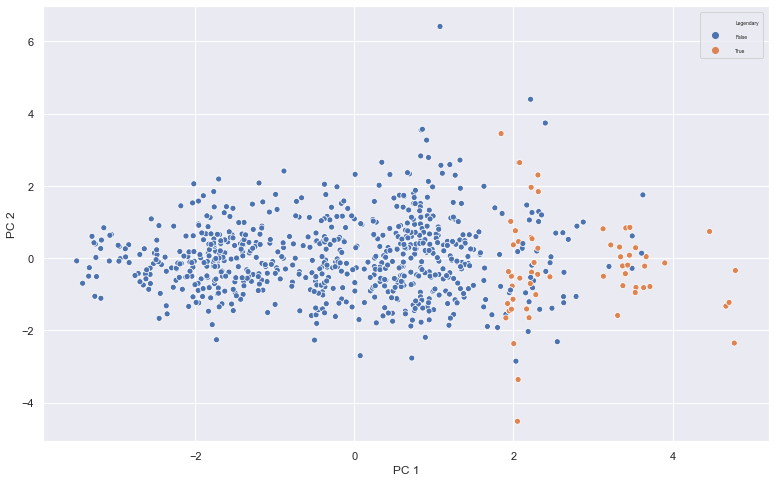

In [79]:
# Use the Type feature to color the PC 1 vs PC 2 scatterplot
plt.figure(figsize=(13,8))

ax = sns.scatterplot(data=poke_cat_df, 
                x='PC 1', y='PC 2', hue='Legendary')

plt.setp(ax.get_legend().get_texts(), fontsize='5') 

plt.show()

Awesome! Looks like the different types are scattered all over the place while the legendary Pokemon always score high for PC 1 meaning they have high stats overall. Their spread along the PC 2 axis tells us they aren't consistently fast and vulnerable or slow and armored.

#### PCA in a model pipeline

We just saw that legendary Pokemon tend to have higher stats overall. Let's see if we can add a classifier to our pipeline that detects legendary versus non-legendary Pokemon based on the principal components.

In [80]:
X = df
y = poke_cat_df['Legendary']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(600, 6)
(600,)
(200, 6)
(200,)


In [81]:
# Build the pipeline
pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('reducer', PCA(n_components = 2)),
        ('classifier', RandomForestClassifier(random_state = 0))])

# Fit the pipeline to the training data
pipe.fit(X_train, y_train)

# Prints the explained variance ratio
print(pipe.steps[1][1].explained_variance_ratio_)

[0.45807909 0.18038909]


In [82]:
# Score the accuracy on the test set
accuracy = pipe.score(X_test, y_test)

# Prints the model accuracy
print('{0:.1%} test set accuracy'.format(accuracy))

95.5% test set accuracy


In [83]:
# Repeat with 3 components
# Build the pipeline
pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('reducer', PCA(n_components=3)),
        ('classifier', RandomForestClassifier(random_state=0))])

# Fit the pipeline to the training data
pipe.fit(X_train, y_train)

# Score the accuracy on the test set
accuracy = pipe.score(X_test, y_test)

# Prints the explained variance ratio and accuracy
print(pipe.steps[1][1].explained_variance_ratio_)
print('{0:.1%} test set accuracy'.format(accuracy))


[0.45807909 0.18038909 0.12816082]
95.0% test set accuracy


In [84]:
# Using features directly rather than PCA

# Fit the random forest model to the training data
rf = RandomForestClassifier(random_state=0)
rf.fit(X_train, y_train)

# Calculate the accuracy
acc = accuracy_score(rf.predict(X_test), y_test)
print('{0:.1%} test set accuracy'.format(acc))

93.5% test set accuracy


#### Selecting the proportion of variance to keep

You'll let PCA determine the number of components to calculate based on an explained variance threshold that you decide.

You'll work on the numeric ANSUR female dataset pre-loaded as ansur_female_df.

In [85]:
ansur_female_df = pd.read_csv('ANSUR_II_FEMALE.csv')

ansur_female_df.shape

(1986, 99)

In [86]:
ansur_female_df_numeric = ansur_female_df.drop(['Gender', 'Branch', 'Component', 'BMI_class', 'Height_class'], axis = 1)

In [87]:
ansur_female_df_numeric.shape

(1986, 94)

In [88]:
# Pipe a scaler to PCA selecting 80% of the variance
pipe = Pipeline([('scaler', StandardScaler()),
        		 ('reducer', PCA(n_components=0.8))])

# Fit the pipe to the data
pipe.fit(ansur_female_df_numeric)

print('{} components selected'.format(len(pipe.steps[1][1].components_)))

11 components selected


In [89]:
# Let PCA select 90% of the variance
pipe = Pipeline([('scaler', StandardScaler()),
        		 ('reducer', PCA(n_components=0.9))])

# Fit the pipe to the data
pipe.fit(ansur_female_df_numeric)

print('{} components selected'.format(len(pipe.steps[1][1].components_)))

23 components selected


#### Choosing the number of components

You'll now make a more informed decision on the number of principal components to reduce your data to using the **"elbow in the plot"** technique.

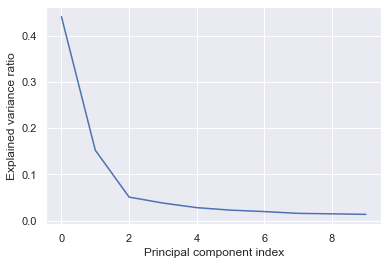

In [90]:
# Pipeline a scaler and pca selecting 10 components
pipe = Pipeline([('scaler', StandardScaler()),
        		 ('reducer', PCA(n_components=10))])

# Fit the pipe to the data
pipe.fit(ansur_female_df_numeric)

# Plot the explained variance ratio
plt.plot(pipe.steps[1][1].explained_variance_ratio_)

plt.xlabel('Principal component index')
plt.ylabel('Explained variance ratio')
plt.show()

#### PCA for image compression
You'll reduce the size of 50 images with hand written digits (MNIST dataset) using PCA.

The samples are 28 by 28 pixel gray scale images that have been flattened to arrays with 784 elements each (28 x 28 = 784) and added to the 2D numpy array X_test. Each of the 784 pixels has a value between 0 and 255 and can be regarded as a feature.

A pipeline with a scaler and PCA model to select 78 components has been pre-loaded for you as pipe. This pipeline has already been fitted to the entire MNIST dataset except for the 50 samples in X_test.

Finally, a function plot_digits has been created for you that will plot 50 images in a grid

In [91]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

X_train = X_train[:150]
X_test = X_test[:50]
y_test = y_test[:50]

In [92]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(150, 28, 28)
(150,)
(50, 28, 28)
(50,)


In [93]:
def plot_digits(data): 
    fig, axes = plt.subplots(5,10, figsize = (6,6), subplot_kw = {'xticks':[], 'yticks':[]}, 
                            gridspec_kw = dict(hspace = 0.05, wspace = 0.05))
    
    for i, ax in enumerate(axes.flat):
        ax.imshow(data[i].reshape(28,28), cmap = 'binary', clim = (0,300))
        
    plt.show()

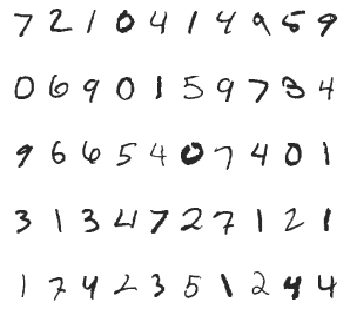

In [94]:
plot_digits(X_test)

The data returned from mnist.load_data() is a 3-dimensional tensor, which we reshape to a matrix. Each row corresponds to one handwritten digit, and each column to a position in the image.

In [95]:
X_train = X_train.reshape(X_train.shape[0], 28*28)
print(X_train.shape)

(150, 784)


In [96]:
X_test = X_test.reshape(X_test.shape[0], 28*28)
print(X_test.shape)

(50, 784)


In [97]:
pipe = Pipeline([('scaler', StandardScaler()),
        		 ('reducer', PCA(n_components=78))])

pipe.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('reducer', PCA(copy=True, iterated_power='auto', n_components=78, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False))])

In [98]:
# Transform the input data to principal components
pc = pipe.transform(X_test)

# Prints the number of features per dataset
print("X_test has {} features".format(X_test.shape[1]))
print("pc has {} features".format(pc.shape[1]))

X_test has 784 features
pc has 78 features


In [99]:
# Inverse transform the components to original feature space
X_rebuilt = pipe.inverse_transform(pc)

# Prints the number of features
print("X_rebuilt has {} features".format(X_rebuilt.shape[1]))

X_rebuilt has 784 features


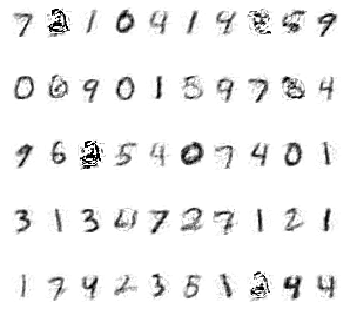

In [100]:
# Plot the reconstructed data
plot_digits(X_rebuilt)

We have reduced the size of the data 10 fold but were able to reconstruct images with reasonable quality.